In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from bigfile import BigFile
import glob,os,struct
from scipy.interpolate import interp1d
from colossus.cosmology import cosmology
import seaborn as sns

sns.set()
sns.set_palette("Set2")
sns.set_style('ticks',{'ytick.direction':'in','xtick.direction':'in'})

cmap = plt.get_cmap("Set2")
sns.set_context("paper", font_scale=1.7,rc={"axes.linewidth": 1.3,"lines.linewidth": 2.5,"patch.linewidth": 2.2})
from matplotlib import rcParams as rc
import matplotlib as mpl

In [4]:
def load_astrid_cosmo():
    pig = BigFile('/hildafs/datasets/Asterix/PIG_files/PIG_214')
    battr = pig["Header"].attrs
    Lbox = battr['BoxSize']
    hh = battr['HubbleParam']
    om0 = battr['Omega0']
    omb = battr['OmegaBaryon']
    oml = battr['OmegaLambda']
    Nfof = battr['NumFOFGroupsTotal']
    sigma8 = 0.82

    # set-up cosmology
    params = {'flat': True, 'H0': 100*hh, 'Om0': om0, 'Ob0': omb, 'sigma8': sigma8, 'ns': 0.96}
    cosmo = cosmology.setCosmology('myCosmo', params)
    MassTable = battr["MassTable"]
    
    return Lbox, MassTable, cosmo

snaps = np.loadtxt('/hildafs/datasets/Asterix/PIG2/Snapshots.txt')
snap2z = {s[0]:1./s[1]-1 for s in snaps}


# some constants and unit conversions
msun_mks = 1.989e30
pc_mks = 3.086e16
grav_mks = 6.67e-11
km_mks = 1e3
yr_mks = 3.154e+7
c_mks = 3e8

Mpc_to_m = 3.086e+22
m_to_Mpc = 1./Mpc_to_m
s_to_year = 3.17098e-8
c_Mpc_yr = c_mks*m_to_Mpc/s_to_year
fac = 121.14740013761634  # GADGET unit Protonmass / Bolztman const
GAMMA = 5 / 3.
Xh=0.76
hh = h = 0.6774

Lbox, MassTable, cosmo = load_astrid_cosmo()
# conversion between time and redshift
z_arr = np.linspace(0,20,1000)
time = cosmo.age(z_arr) # Gyr
def z_to_t(x):
    return interp1d(z_arr, time,fill_value='extrapolate')(x)
def t_to_z(x):
    return interp1d(time, z_arr,fill_value='extrapolate')(x) 

In [29]:
c_mks = 3e8
msun_mks = 2e30
s_to_year = 3.17098e-8
year_to_s = 1./s_to_year
lsun_ergs = 3.9e33
mdot_msun_yr = 1e10/980/1e6
def calc_lx(mdot):
    """
    input: mdot in Msun/yr
    output: Lx in ergs
    """
    lbol = 0.1*mdot*msun_mks/year_to_s*c_mks**2
    lbol_lsun = lbol/3.9e26
    k = 10.83*(lbol_lsun/1e10)**0.28 \
        + 6.08*(lbol_lsun/1e10)**(-0.02)
    return lbol/k*1e7

def calc_lbol(mdot):
    """
    input: mdot in Msun/yr
    output: Lx in ergs
    """
    lbol = 0.1*mdot*msun_mks/year_to_s*c_mks**2
    lbol_ergs = lbol*1e7
    return lbol_ergs

def edd_ratio(mass,lum):
    return lum/(1.26e38*mass)


In [5]:
merger_root = "/hildafs/datasets/Asterix/BH-mergers"
merger_files = glob.glob(merger_root + "/bh-merger-extended*.npy")
merger_files.sort()

mergers = []
for file in merger_files:
    mergers.append(np.load(file))
mergers = np.concatenate(mergers)

print("merger data fields:", mergers.dtype.names)
print("merger shape:", mergers.shape)

swbh = np.minimum(mergers["ID1"], mergers["ID2"])

uid, uidx = np.unique(swbh, return_index=True)
mergers = mergers[uidx]

print("unique mergers:", len(mergers))


merger data fields: ('z', 'ID1', 'ID2', 'm1', 'm2', 'mdot1', 'mdot2', 'pos1', 'pos2', 'v1', 'v2')
merger shape: (2458765,)
unique mergers: 2299446


### merger rate

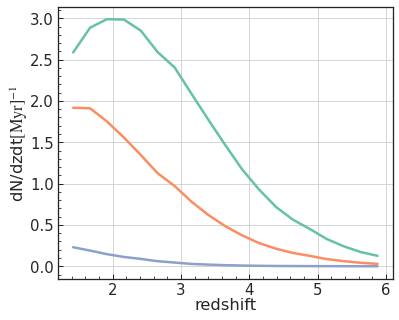

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
vsim = 250**3
zbin = np.linspace(1.3,6,20)
dz = zbin[1:] - zbin[:-1]
zc = 0.5*(zbin[1:]+zbin[:-1])
rc = np.array([cosmo.comovingDistance(0.,zz) for zz in zc])

n0,e0 = np.histogram(np.concatenate([mergers['z']]),bins=zbin)

rate0 = n0/dz/vsim*4*np.pi*rc**2*c_Mpc_yr

ax.plot(zc, rate0, label="all")
ax.grid()
ax.set(xlabel="redshift", ylabel=r"dN/dzdt$\rm{[Myr]^{-1}}$")


mask = mergers["m1"] > 1e5
mask &= mergers["m2"] > 1e5

vsim = 250**3
zbin = np.linspace(1.3,6,20)
dz = zbin[1:] - zbin[:-1]
zc = 0.5*(zbin[1:]+zbin[:-1])
rc = np.array([cosmo.comovingDistance(0.,zz) for zz in zc])

n0,e0 = np.histogram(np.concatenate([mergers[mask]['z']]),bins=zbin)

rate0 = n0/dz/vsim*4*np.pi*rc**2*c_Mpc_yr

ax.plot(zc, rate0, label="M>1e5, x10")


mask = mergers["m1"] > 1e6
mask &= mergers["m2"] > 1e6

vsim = 250**3
zbin = np.linspace(1.3,6,20)
dz = zbin[1:] - zbin[:-1]
zc = 0.5*(zbin[1:]+zbin[:-1])
rc = np.array([cosmo.comovingDistance(0.,zz) for zz in zc])

n0,e0 = np.histogram(np.concatenate([mergers[mask]['z']]),bins=zbin)

rate0 = n0/dz/vsim*4*np.pi*rc**2*c_Mpc_yr

ax.plot(zc, rate0, label="M>1e6, x10")

# ax.set(yscale="log")


# plt.yscale('log')

### properties

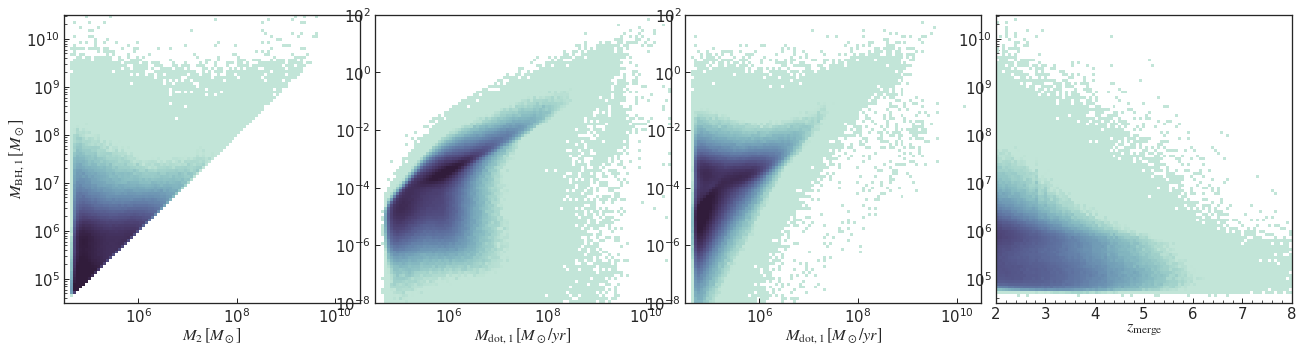

In [7]:
cc3 = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)

fig, ax = plt.subplots(1,4,figsize=(22,5.3))
plt.subplots_adjust(wspace=0.05)
ax = ax.flatten()


ymin, ymax = 4.5, 10.5
xmin, xmax = 4.5, 10.5

xbins = np.logspace(xmin,xmax, 100)
ybins = np.logspace(ymin,ymax, 100)
ax[0].hist2d(mergers['m2'], mergers['m1'], bins = [xbins, ybins], cmap=cc3,  cmin=1, norm=mpl.colors.LogNorm(vmin=50, vmax=8000))
ax[0].set(xscale='log', yscale='log', xlabel=r'$M_{2}\,[M_\odot]$', ylabel=r'$M_{\rm BH, 1}\,[M_\odot]$')


xmin, xmax = 4.5, 10.5
ymin, ymax = -8, 2

xbins = np.logspace(xmin,xmax, 100)
ybins = np.logspace(ymin,ymax, 100)

ax[1].hist2d(mergers['m1'], mergers['mdot1'], bins = [xbins, ybins], cmap=cc3,  cmin=1, norm=mpl.colors.LogNorm(vmin=50, vmax=8000))
ax[1].set(xscale='log', yscale='log', xlabel=r'$M_{\rm dot, 1}\,[M_\odot/yr]$')


xmin, xmax = 4.5, 10.5
ymin, ymax = -8, 2

xbins = np.logspace(xmin,xmax, 100)
ybins = np.logspace(ymin,ymax, 100)

ax[2].hist2d(mergers['m2'], mergers['mdot2'], bins = [xbins, ybins], cmap=cc3,  cmin=1, norm=mpl.colors.LogNorm(vmin=50, vmax=8000))
ax[2].set(xscale='log', yscale='log', xlabel=r'$M_{\rm dot, 1}\,[M_\odot/yr]$')




ymin, ymax = 4.5, 10.5
xmin, xmax = 2, 8

xbins = np.linspace(xmin,xmax, 100)
ybins = np.logspace(ymin,ymax, 100)

ax[3].hist2d(mergers['z'], mergers['m1'], bins = [xbins, ybins], cmap=cc3,  cmin=1, norm=mpl.colors.LogNorm(vmin=50, vmax=8000))
ax[3].set(yscale='log', xlabel=r'$z_{\rm merge}$')



plt.show()

In [6]:
# root = "/hildafs/home/nianyic/scratch1/Astrid_data/lisa_mbhcat"
# np.save(root + "/lisa_mcat_v1.0_z1.3.npy", data_unique)

### sanity checks

In [14]:
root = "/hildafs/home/nianyic/scratch1/Astrid_data/lisa_mbhcat"

data1 = np.load(root + "/lisa_mcat_v1.0_z1.3.npy")
zmin = min(data1["zmerge"])
print("number of mergers in v1.0:", len(data1))
print("v1.0 dtype:", data1.dtype)


data2 = np.load(root + "/lisa_mcat_v2.0_nogal.npy")
mask = data2["z"] >= zmin
data2 = data2[mask]

print("number of mergers in v2.0:", len(data2))
print("v2.0 dtype:", data2.dtype)

number of mergers in v1.0: 1893110
v1.0 dtype: [('id1', '<i8'), ('id2', '<i8'), ('zmerge', '<f8'), ('m1', '<f8'), ('m2', '<f8'), ('mstot', '<f8'), ('zsnap', '<f8')]
number of mergers in v2.0: 1905412
v2.0 dtype: [('z', '<f8'), ('ID1', '<i8'), ('ID2', '<i8'), ('m1', '<f8'), ('m2', '<f8'), ('mdot1', '<f8'), ('mdot2', '<f8'), ('pos1', '<f8', (3,)), ('pos2', '<f8', (3,)), ('v1', '<f8', (3,)), ('v2', '<f8', (3,))]


(1905412, 3)


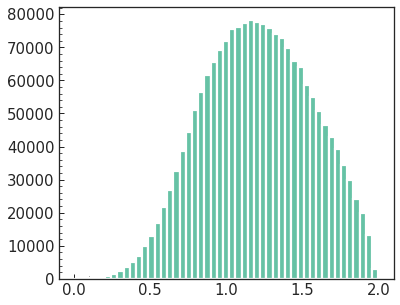

In [20]:
# get dr
box = 250000.
dpos = data2["pos1"] - data2["pos2"]
print(dpos.shape)

dpos[dpos > box/2] -= box
dpos[dpos < -box/2] += box

dr = np.linalg.norm(dpos, axis=1)
dr_kpc = dr / (1 + data2["z"]) / hh

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.hist(dr_kpc, bins=np.linspace(0,2,50))
plt.show()


#### combine data: get dr info from v2.0 and get mstot, zsnap from v1.0

In [23]:
minid1 = np.minimum(data1["id1"], data1["id2"])
dict1 = {minid1[i]: d for i, d in enumerate(data1)}

print(len(data1), len(dict1.keys()))

minid2 = np.minimum(data2["ID1"], data2["ID2"])



1893110 1893110


In [24]:
dtype_new = np.dtype([('z', '<f8'), ('ID1', '<i8'), ('ID2', '<i8'), ('m1', '<f8'), ('m2', '<f8'), ('mdot1', '<f8'), ('mdot2', '<f8'), ('mstot', '<f8'), ('zsnap', '<f8'), ('dr', '<f8')])
data_new = []

for i, d2 in enumerate(data2):
    if minid2[i] not in dict1:
        continue
    mstot = dict1[minid2[i]]["mstot"]
    zsnap = dict1[minid2[i]]["zsnap"]
    dr = dr_kpc[i]
    
    data_new.append((d2["z"], d2["ID1"], d2["ID2"], d2["m1"], d2["m2"], d2["mdot1"], d2["mdot2"], mstot, zsnap, dr))
    
    


In [26]:
print(len(data_new))
data_new = np.array(data_new, dtype=dtype_new)

1887462


In [27]:
vsim = 250**3
zbin = np.linspace(1.316,6,40)
dz = zbin[1:] - zbin[:-1]
zc = 0.5*(zbin[1:]+zbin[:-1])
rc = np.array([cosmo.comovingDistance(0.,zz) for zz in zc])

n0,e0 = np.histogram(data_new["z"],bins=zbin)
rate0 = n0/dz/vsim*4*np.pi*rc**2*c_Mpc_yr

Text(0.5, 1.0, 'Merger Rate')

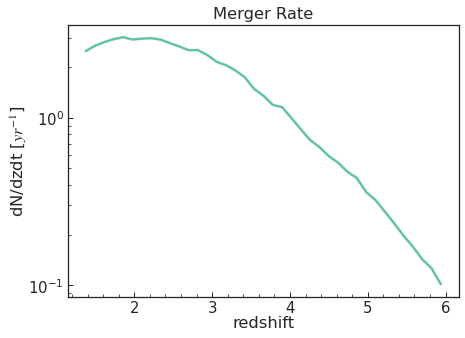

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.plot(zc, rate0)
ax.set(xlabel="redshift", ylabel=r"dN/dzdt [$yr^{-1}$]", yscale="log")
# plt.yscale('log')
ax.set_title("Merger Rate")


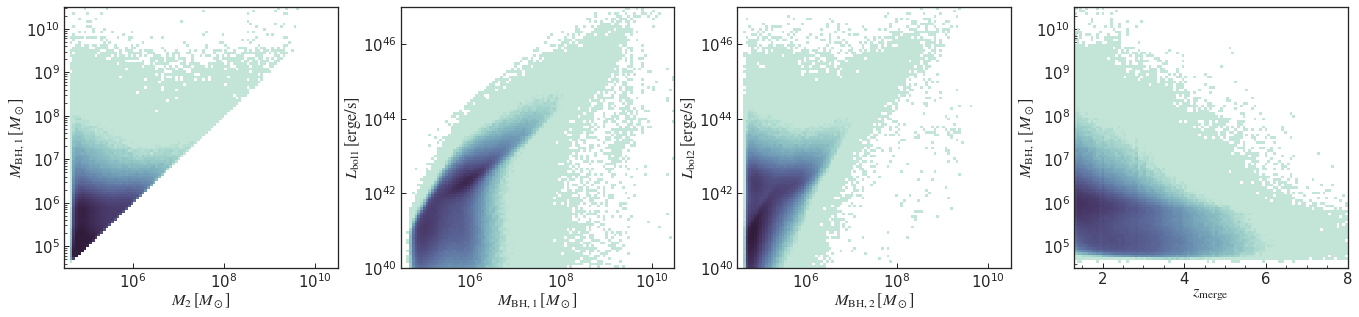

In [38]:
mergers = data_new

cc3 = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)

fig, ax = plt.subplots(1,4,figsize=(23,4.8))
plt.subplots_adjust(wspace=0.23)
ax = ax.flatten()


ymin, ymax = 4.5, 10.5
xmin, xmax = 4.5, 10.5

xbins = np.logspace(xmin,xmax, 100)
ybins = np.logspace(ymin,ymax, 100)
ax[0].hist2d(mergers['m2'], mergers['m1'], bins = [xbins, ybins], cmap=cc3,  cmin=1, norm=mpl.colors.LogNorm(vmin=50, vmax=8000))
ax[0].set(xscale='log', yscale='log', xlabel=r'$M_{2}\,[M_\odot]$', ylabel=r'$M_{\rm BH, 1}\,[M_\odot]$')


xmin, xmax = 4.5, 10.5
ymin, ymax = 40,47

xbins = np.logspace(xmin,xmax, 100)
ybins = np.logspace(ymin,ymax, 100)

lbol1 = calc_lbol(mergers["mdot1"])
lbol2 = calc_lbol(mergers["mdot2"])

ax[1].hist2d(mergers['m1'], lbol1, bins = [xbins, ybins], cmap=cc3,  cmin=1, norm=mpl.colors.LogNorm(vmin=50, vmax=8000))
ax[1].set(xscale='log', yscale='log', xlabel=r'$M_{\rm BH, 1}\,[M_\odot]$', ylabel=r"$L_{\rm bol1}\,[{\rm erge/s}]$")


xmin, xmax = 4.5, 10.5
ymin, ymax = 40,47

xbins = np.logspace(xmin,xmax, 100)
ybins = np.logspace(ymin,ymax, 100)

ax[2].hist2d(mergers['m2'], lbol2, bins = [xbins, ybins], cmap=cc3,  cmin=1, norm=mpl.colors.LogNorm(vmin=50, vmax=8000))
ax[2].set(xscale='log', yscale='log', xlabel=r'$M_{\rm BH, 2}\,[M_\odot]$', ylabel=r"$L_{\rm bol2}\,[\rm {erge/s}]$")




ymin, ymax = 4.5, 10.5
xmin, xmax = 1.3, 8

xbins = np.linspace(xmin,xmax, 100)
ybins = np.logspace(ymin,ymax, 100)

ax[3].hist2d(mergers['z'], mergers['m1'], bins = [xbins, ybins], cmap=cc3,  cmin=1, norm=mpl.colors.LogNorm(vmin=50, vmax=8000))
ax[3].set(yscale='log', xlabel=r'$z_{\rm merge}$', ylabel=r'$M_{\rm BH, 1}\,[M_\odot]$')



plt.show()

In [39]:
savedir = "/hildafs/home/nianyic/scratch1/Astrid_data/lisa_mbhcat/lisa_mcat_v2.0_z1.3.npy"
np.save(savedir, data_new)

### all bh catalog

In [40]:
catdir = "/hildafs/datasets/Asterix/subfind/reduced_catalog"
file = catdir + "/ASTRID_subfind_galaxy_catalog_214.npy"
cat = np.load(file)
print(cat.dtype)

[('Mstar', '<f8'), ('MassCenterPos', '<f8', (3,)), ('SFR', '<f8'), ('MBH', '<f8'), ('MBHdot', '<f8'), ('numBH', '<i4')]
